# Hurricane Ida

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

In [2]:
from datetime import datetime
from pansat.products.satellite.gpm import l1c_gpm_gmi_r

In [3]:
from matplotlib import style
import seaborn as sns
sns.reset_orig()
cmap = sns.color_palette("rocket", as_cmap=True)
style.use("plots.mplstyle")

## GPM L1C

In [12]:
from datetime import timedelta
start_time = datetime(2021, 8, 29, 15, 13)
files = l1c_gpm_gmi_r.download(start_time, start_time)

In [13]:
files

[PosixPath('GPM/1C-R.GPM.GMI.XCAL2016-C.20210829-S144151-E161423.042624.V07A.HDF5')]

In [9]:
files = ['GPM/1C-R.GPM.GMI.XCAL2016-C.20210829-S144151-E161423.042624.V05A.HDF5']

In [6]:
files

[]

In [14]:
l1c_data = l1c_gpm_gmi_r.open(files[0])

In [16]:
scan_time = l1c_data.scan_time.data
overpass_time = np.datetime64("2021-08-29T15:13:00")
i = np.argmin(np.abs(scan_time - overpass_time))
lat_0 = l1c_data.latitude_s1[i].data.mean()
lon_0 = l1c_data.longitude_s1[i].data.mean()

## GPM DPR


In [17]:
from pansat.products.satellite.gpm import l1b_dpr_ku

In [18]:
files

[PosixPath('GPM/1C-R.GPM.GMI.XCAL2016-C.20210829-S144151-E161423.042624.V07A.HDF5')]

In [10]:
import re
e = re.compile(".*.(h5|HDF5)")
e.match("hallo.HDF5")

<re.Match object; span=(0, 10), match='hallo.HDF5'>

In [19]:
files = ["GPM/2A.GPM.Ku.V8-20180723.20210829-S144151-E161423.042624.V06A.HDF5"]

In [20]:
from h5py import File
dpr_pr = File(files[0])["NS/SLV/precipRate"][:, 19]
lats_dpr = File(files[0])["NS/Latitude"][:, 19]
lons_dpr = File(files[0])["NS/Longitude"][:, 19]

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'GPM/2A.GPM.Ku.V8-20180723.20210829-S144151-E161423.042624.V06A.HDF5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [14]:
i_dpr = np.argmin((lat_0 - lats_dpr) ** 2 + (lon_0 - lons_dpr) ** 2)
i_dpr

2599

In [15]:
from gprof_nn.utils import great_circle_distance
i_start = i_dpr
i_end = i_dpr + 200
lats_dpr = lats_dpr[i_start:i_end]
lons_dpr = lons_dpr[i_start:i_end]
dpr_pr = dpr_pr[i_start:i_end, ::-1]
z_dpr = np.arange(dpr_pr.shape[1]) * 250


In [16]:
d_dpr = great_circle_distance(lats_dpr[0], lons_dpr[0], lats_dpr, lons_dpr)

In [17]:
dpr_pr[dpr_pr < 0] = np.nan

/tmp/ipykernel_28359/710768984.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(lats_dpr, z_dpr, dpr_pr.T)


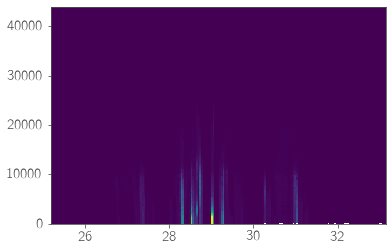

In [18]:
plt.pcolormesh(lats_dpr, z_dpr, dpr_pr.T)

## Area definition

In [21]:
lat_0

25.413298

In [22]:
from satpy.scene import Scene
import satpy.writers
from pyresample.geometry import AreaDefinition

area_id = 'Ida'
description = 'Projection centered on hurricane dorian'
proj_id = 'LAEA'
projection = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'}
width = 512
height = 512
area_extent = (-500e3, -500e3, 1000e3, 1000e3)
area = AreaDefinition(area_id, description, proj_id, projection,
                      width, height, area_extent)


## GPM TBs

In [27]:
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest
lons = l1c_data.longitude_s1.data
lats = l1c_data.latitude_s1.data

swath = SwathDefinition(lons, lats)
tbs_s1 = l1c_data.tbs_s1.data.copy()
tbs_s1[tbs_s1 < 0] = np.nan

tbs_s2 = l1c_data.tbs_s2.data
tbs_s2[tbs_s2 < 0] = np.nan

tbs_1_r = resample_nearest(
    swath,
    tbs_s1,
    area,
    fill_value=np.nan,
    radius_of_influence=7.5e3
)
tbs_2_r = resample_nearest(
    swath,
    tbs_s2,
    area,
    fill_value=np.nan,
    radius_of_influence=7.5e3
)


## GOES 16

In [28]:
goes_files

NameError: name 'goes_files' is not defined

In [31]:
from pathlib import Path
import pandas as pd
from datetime import timedelta
from pansat.products.satellite.goes import GOES16L1BRadiances
from satpy import Scene
from PIL import Image
goes_files = list(Path("GOES-16/GOES-16-ABI-L1b-RadC/").glob("*s202124115111*.nc"))
if not Path("ida.png").exists():
    #goes = GOES16L1BRadiances("C", [1, 2, 3, 5, 9, 13])
    #time = pd.Timestamp(overpass_time).to_pydatetime()
    #start_time = time - timedelta(minutes=5)
    #end_time = time + timedelta(minutes=5)
    #goes_files = goes.download(start_time, end_time)

    scene = Scene([str(f) for f in goes_files])
    scene.load(["true_color", "C05", "C13"])
    scene_r = scene.resample(area, radius_of_influence=5e3)
    scene_r.save_dataset("true_color", "ida.png")
    
    scene_r.save_dataset("C05", "goes_05.nc")
    scene_r.save_dataset("C13", "goes_13.nc")
    
goes_tc = Image.open("ida.png")
goes_c5 = xr.load_dataset("goes_05.nc")
goes_c13 = xr.load_dataset("goes_13.nc")

satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: avhrr_l1b_eps
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: seviri_l1b_native
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: electrol_hrit
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: mviri_l1b_fiduceo_nc
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: olci_l2
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: viirs_l1b
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: fci_l1c_fdhsi
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: seviri_l2_bufr
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: hy2_scat_l2b_h5
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: vii_l1b_nc
satpy.readers.yaml_reader (WARNING   ) :: No filenames found for reader: ami_l1b
satpy.readers.yaml_reader (WARNING   ) :: No fil

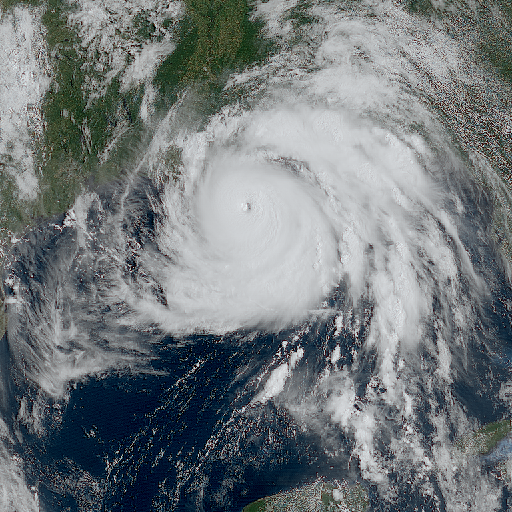

In [32]:
goes_tc

In [33]:
x_min, y_min, x_max, y_max = area.area_extent

NameError: name 'lons_dpr' is not defined

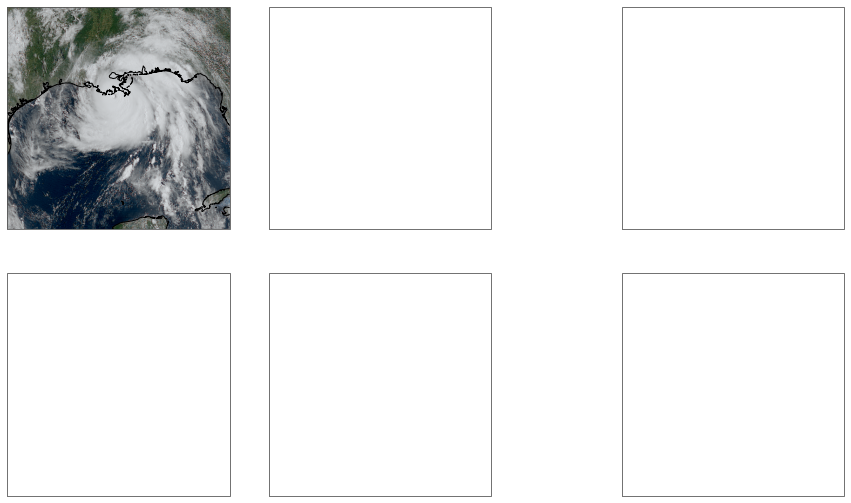

In [34]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs

f = plt.figure(figsize=(16, 9))
gs = GridSpec(2, 6, width_ratios=[1.0, 1.0, 0.07, 0.1, 1.0, 0.07])
crs = area.to_cartopy_crs()
axs = np.array([
    [f.add_subplot(gs[i, j], projection=crs) for j in [0, 1, 4]] for i in range(2)
] )
extent = (x_min, x_max, y_min, y_max)

# True color

ax = axs[0, 0]
ax.imshow(goes_tc, extent=extent)
x_min, y_min, x_max, y_max = area.area_extent
ax.set_extent((x_min, x_max, y_min, y_max), crs=crs)
axs[0, 0].coastlines()
ax.plot(lons_dpr, lats_dpr, transform=ccrs.PlateCarree(), c="salmon", ls="--")
ax.scatter(lons_dpr[[0, -1]], lats_dpr[[0, -1]], marker="x", c="salmon", transform=ccrs.PlateCarree())
ax.text(lons_dpr[0] - 0.2, lats_dpr[0], s="A", ha="right", transform=ccrs.PlateCarree(), color="salmon", fontsize="14")
ax.text(lons_dpr[-1] - 0.2, lats_dpr[-1], s="B", ha="right", transform=ccrs.PlateCarree(), color="salmon", fontsize="14")
ax.set_title("(a) True color", loc="left")

# 1.6 um

ax = axs[0, 1]
data = goes_c5["C05"].data
m = ScalarMappable(norm=Normalize(), cmap="Greys_r")
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(b) $\lambda = 1.6$ $\mu$m", loc="left")

ax = f.add_subplot(gs[0, 2])
plt.colorbar(m, cax=ax, label="Reflectivity [$W m^{-2}$]")

# 10.3 um

ax = axs[0, 2]
m = ScalarMappable(norm=Normalize(), cmap="plasma")
data = goes_c13["C13"].data
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.set_title("(c) $\lambda = 10.3$ $\mu$m", loc="left")

ax = f.add_subplot(gs[0, -1])
plt.colorbar(m, cax=ax, label="Brightess temperature [K]")

# Microwave 

ax = axs[1, 0]
data = tbs_1_r[:, :, 0]
ax.imshow(goes_tc, extent=extent)
m = ScalarMappable(norm=Normalize(150, 300), cmap="plasma")
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(c) $\lambda = 3$ cm", loc="left")

ax = axs[1, 1]
data = tbs_2_r[:, :, 0]
ax.imshow(goes_tc, extent=extent)
m = ScalarMappable(norm=Normalize(150, 300), cmap="plasma")
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(d) $\lambda = 0.3$ cm", loc="left")

ax = f.add_subplot(gs[1, 2])
plt.colorbar(m, cax=ax, label="Brightess temperature [K]")

ax = f.add_subplot(gs[1, 4])
m = ax.pcolormesh(d_dpr / 1e3, z_dpr / 1e3, np.log10(200.0 * np.maximum(dpr_pr.T, 1e-2) ** 1.8), cmap="plasma")
ax.set_ylim([0, 25])
ax.set_title("(e) Radar ($\lambda = 2.2$ cm)", loc="left")
ax.set_ylabel("Altitude [km]")
ax.set_xlabel("Distance [km]")

xticks = ax.get_xticks()
xticks[1] = d_dpr[0] / 1e3
xticks[-1] = d_dpr[-1] / 1e3
ax.set_xticks(xticks[1:])

ticklabels = []
for val in xticks[1:]:
    ticklabels.append(f"{val:0.2f}")
ticklabels[0] = "A"
ticklabels[-1] = "B"
    

ax.set_xticklabels(ticklabels)



ax = f.add_subplot(gs[1, -1])
plt.colorbar(m, cax=ax, label="Radar refl. [dB Z]")
f.savefig("observations.png", dpi=300, bbox_inches="tight")

/home/simonpf/miniconda3/envs/satpy/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/simonpf/miniconda3/envs/satpy/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/simonpf/miniconda3/envs/satpy/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/tmp/ipykernel_1801587/988745532.py:87: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor rel

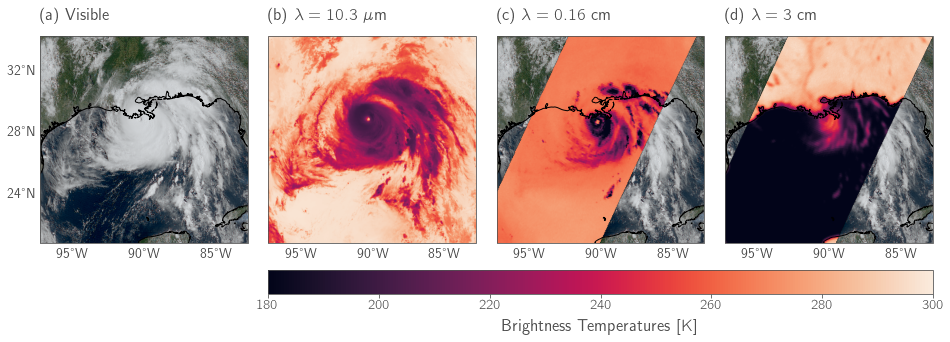

In [35]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.ticker as mticker
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs

f = plt.figure(figsize=(16, 5))
gs = GridSpec(2, 4, height_ratios=[1.0, 0.1], hspace=0.1, wspace=0.1)
crs = area.to_cartopy_crs()
axs = np.array([f.add_subplot(gs[0, j], projection=crs) for j in range(4)])
extent = (x_min, x_max, y_min, y_max)

norm = Normalize(180, 300)
# True color

ax = axs[0]
ax.imshow(goes_tc, extent=extent)
x_min, y_min, x_max, y_max = area.area_extent
ax.set_extent((x_min, x_max, y_min, y_max), crs=crs)
ax.coastlines()
ax.set_title("(a) Visible", loc="left")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}

# 10.3 um

ax = axs[1]
m = ScalarMappable(norm=norm, cmap=cmap)
data = goes_c13["C13"].data
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.set_title("(b) $\lambda = 10.3$ $\mu$m", loc="left")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}


# Microwave 

ax = axs[2]
data = tbs_2_r[:, :, -1]
ax.imshow(goes_tc, extent=extent)
m = ScalarMappable(norm=norm, cmap=cmap)
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(c) $\lambda = 0.16$ cm", loc="left")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}


ax = axs[3]
data = tbs_1_r[:, :, 0]
ax.imshow(goes_tc, extent=extent)
m = ScalarMappable(norm=norm, cmap=cmap)
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(d) $\lambda = 3$ cm", loc="left")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}



ax = f.add_subplot(gs[1, 1:])
plt.colorbar(m, cax=ax, label="Brightness Temperatures [$\si{\kelvin}$]", orientation="horizontal")
f.savefig("observations_ida.svg", dpi=300, bbox_inches="tight")

/home/simonpf/miniconda3/envs/satpy/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/simonpf/miniconda3/envs/satpy/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/simonpf/miniconda3/envs/satpy/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/tmp/ipykernel_1801587/2698696326.py:87: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor re

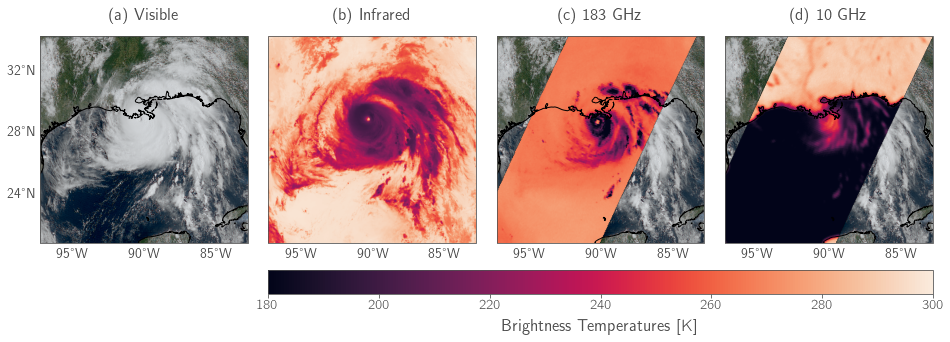

In [38]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize, LogNorm
import matplotlib.ticker as mticker
from matplotlib.cm import ScalarMappable
import cartopy.crs as ccrs

f = plt.figure(figsize=(16, 5))
gs = GridSpec(2, 4, height_ratios=[1.0, 0.1], hspace=0.1, wspace=0.1)
crs = area.to_cartopy_crs()
axs = np.array([f.add_subplot(gs[0, j], projection=crs) for j in range(4)])
extent = (x_min, x_max, y_min, y_max)

norm = Normalize(180, 300)
# True color

ax = axs[0]
ax.imshow(goes_tc, extent=extent)
x_min, y_min, x_max, y_max = area.area_extent
ax.set_extent((x_min, x_max, y_min, y_max), crs=crs)
ax.coastlines()
ax.set_title("(a) Visible")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}

# 10.3 um

ax = axs[1]
m = ScalarMappable(norm=norm, cmap=cmap)
data = goes_c13["C13"].data
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.set_title("(b) Infrared")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}


# Microwave 

ax = axs[2]
data = tbs_2_r[:, :, -1]
ax.imshow(goes_tc, extent=extent)
m = ScalarMappable(norm=norm, cmap=cmap)
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(c) 183 GHz")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}


ax = axs[3]
data = tbs_1_r[:, :, 0]
ax.imshow(goes_tc, extent=extent)
m = ScalarMappable(norm=norm, cmap=cmap)
img = m.to_rgba(data)
ax.imshow(img, extent=extent)
ax.coastlines()
ax.set_title("(d) 10 GHz")

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, color="none", alpha=0.5)
gl.ylocator = mticker.FixedLocator(np.linspace(24, 32, 3))
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.ylabel_style = {'color': '#505050'}
gl.xlabel_style = {'color': '#505050'}



ax = f.add_subplot(gs[1, 1:])
plt.colorbar(m, cax=ax, label="Brightness Temperatures [$\si{\kelvin}$]", orientation="horizontal")
f.savefig("observations_ida.svg", dpi=300, bbox_inches="tight")

## Hurricane Nicole

In [28]:
from datetime import datetime

In [29]:
start_time = datetime(2016, 10, 12, 17, 55)

In [30]:
from pansat.products.satellite.cloud_sat import l1b_cpr
cloudsat_files = l1b_cpr.download(start_time, start_time)

Please enter your pansat user password:
········


ImportError: libffi.so.7: cannot open shared object file: No such file or directory

In [8]:
cloudsat_files = [
    'CloudSat/1B-CPR/2016286165739_55639_CS_1B-CPR_GRANULE_P_R05_E06_F01.hdf'
]

In [7]:
cloudsat_files = [
    'CloudSat/1B-CPR/2016286165739_55639_CS_1B-CPR_GRANULE_P_R05_E06_F01.hdf'
]

In [10]:
modis_files = [
    'MODIS/MYD021KM.A2016286.1755.061.2018062215101.hdf'
]

In [3]:
from pansat.products.satellite.modis import modis_aqua_1km, modis_aqua_geo
#modis_files = modis_aqua_1km.download(start_time, start_time)
modis_files = modis_aqua_geo.download(start_time, start_time)

Please enter your pansat user password:
········


In [9]:
from pathlib import Path
modis_files = list(Path("MODIS").glob("*.hdf"))

In [10]:
modis_files

[PosixPath('MODIS/MYD021KM.A2016286.1755.061.2018062215101.hdf'),
 PosixPath('MODIS/MYD03.A2016286.1755.061.2018062032624.hdf')]

In [11]:
lon_0 = -66.5
lat_0 = 29.0

In [12]:
from satpy.scene import Scene
import satpy.writers
from pyresample.geometry import AreaDefinition

area_id = 'Nicole'
description = 'Projection centered on hurricane nicole'
proj_id = 'LAEA'
projection = {'proj': 'laea', 'lat_0': lat_0, 'lon_0': lon_0, 'a': 6371228.0, 'units': 'm'}
width = 512
height = 512
area_extent = (-500e3, -500e3, 1000e3, 1000e3)
area = AreaDefinition(area_id, description, proj_id, projection,
                      width, height, area_extent)


In [13]:
[str(f) for f in modis_files]

['MODIS/MYD021KM.A2016286.1755.061.2018062215101.hdf',
 'MODIS/MYD03.A2016286.1755.061.2018062032624.hdf']

In [14]:
%ls -ltrh MODIS

total 185M
-rw-r--r-- 1 simonpf gem 150M apr 22 08:06 MYD021KM.A2016286.1755.061.2018062215101.hdf
-rw-r--r-- 1 simonpf gem  36M apr 22 08:14 MYD03.A2016286.1755.061.2018062032624.hdf


In [15]:
from satpy import Scene
scene = Scene([str(f) for f in modis_files], reader="modis_l1b")

satpy.readers (WARNING   ) :: Don't know how to open the following files: {'MODIS/MYD021KM.A2016286.1755.061.2018062215101.hdf', 'MODIS/MYD03.A2016286.1755.061.2018062032624.hdf'}


ValueError: No supported files found

In [15]:
modis_files

[PosixPath('MODIS/MYD021KM.A2016286.1755.061.2018062215101.hdf'),
 PosixPath('MODIS/MYD03.A2016286.1755.061.2018062032624.hdf')]